# 1. Load dataset

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import random, math, time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

#make our work comparable if restarted the kernel
SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

cuda


In [4]:
from sklearn.model_selection import train_test_split

# File paths
myanmar_file_path = './dataset/data_myn.txt'
english_file_path = './dataset/data_eng.txt'

# Read the files
with open(myanmar_file_path, 'r', encoding='utf-8') as myfile:
    myanmar_lines = myfile.readlines()

with open(english_file_path, 'r', encoding='utf-8') as engfile:
    english_lines = engfile.readlines()

# Pair the lines
paired_lines = list(zip(myanmar_lines, english_lines))

#### clean the words

In [5]:
import re

def clean_text(text):
    
    # Remove numerical indices, tabs, and special characters except alphabetic and spaces
    cleaned_text = re.sub('[^A-Za-z0-9က-၏ဠ-ဿ၀-၉၊။ ]+', '', text)
    cleaned_text = re.sub('\d+', '', cleaned_text)
    return cleaned_text.strip()

In [6]:
cleaned_data = {(clean_text(myanmar), clean_text(english)) for myanmar, english in paired_lines}

### converting to panda dataframe

In [7]:
import pandas as pd
df = pd.DataFrame(cleaned_data, columns=['Myanmar', 'English'])
df[:5]

,Myanmar,English
0,အမေရိကမှာ အင်္ဂလိပ်စာကို သုံးလ လေ့လာခဲ့တယ်။,I studied English in America for three months
1,လာမယ့်လမှာ တပည့်အသစ် လာမယ်လို့ ကြားတယ်။,A new student will be coming next month
2,နေ့တိုင်း အလုပ်များလို့ သိပ် အနားမယူနိုင်ဘူး။,I am busy every day so I cannot really rest
3,မနေ့တုန်းကညစာက အသားဟင်းနဲ့ပါ။,Yesterdays dinner was a meat dish
4,မနက်ဖန် အပူချိန် သုံးဆယ်ဒီဂရီအထိ မြင့်မှာဆိုတေ...,It will be degrees tomorrow so it will be hot


In [8]:
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)

In [9]:
test_df, val_df = train_test_split(temp_df, test_size=0.5, random_state=42)

In [10]:
train_df.to_csv('train_data.csv', index=False)
test_df.to_csv('test_data.csv', index=False)
val_df.to_csv('val_data.csv', index=False)


### after spliting train, test and valid dataset, then uploaded to hugging face and download it

In [11]:
import datasets

en_my_corpus = datasets.load_dataset('KaungHtetCho/MT-myanmar-english')

/home/koala/.local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
en_my_corpus

DatasetDict({
    train: Dataset({
        features: ['Myanmar', 'English'],
        num_rows: 1093
    })
    validation: Dataset({
        features: ['Myanmar', 'English'],
        num_rows: 137
    })
    test: Dataset({
        features: ['Myanmar', 'English'],
        num_rows: 137
    })
})

In [13]:
train_size      = len(en_my_corpus['train'])
validation_size = len(en_my_corpus['validation'])
test_size       = len(en_my_corpus['test'])

print('train_size: ', train_size)
print('test_size: ', test_size)
print('validation_size: ', validation_size)

train_size:  1093
test_size:  137
validation_size:  137


# 2. Preprocessing

### Tokenization

####  ***Credit to Dr Ye Kyaw Thu for word-segmentor for Myanmar language***

####   https://github.com/ye-kyaw-thu/myWord

In [14]:
# Credit to Dr Ye Kyaw Thu for word-segmentor for Myanmar language

# Place-holders

token_transform = {}
vocab_transform = {}

"""

This code is updated version of this: https://gist.github.com/markdtw/e2a4e2ee7cef8ea6aed33bb47a97fba6
Ye Kyaw Thu, LST, NECTEC, Thailand updated followings:
-- added recursion limit
-- changed P_unigram and P_bigram as module level global variable
-- using binary ngram dictionary
--  set N value of this: "def __init__(self, datafile=None, unigram=True, N=102490):"
-- Last Updated: 5 Sept 2021

# References:
- Python implementation of Viterbi algorithm for word segmentation: 
- Updated version of this: https://gist.github.com/markdtw/e2a4e2ee7cef8ea6aed33bb47a97fba6
- A clean-up of this: http://norvig.com/ngrams/ch14.pdf
- For recursion limit: https://www.geeksforgeeks.org/python-handling-recursion-limit/
- A. Viterbi, "Error bounds for convolutional codes and an asymptotically optimum decoding algorithm," in IEEE Transactions on Information Theory, vol. 13, no. 2, pp. 260-269, April 1967, doi: 10.1109/TIT.1967.1054010.

"""

import math
import functools
import sys
import pickle


sys.setrecursionlimit(10**6)


uni_dict_bin = './dict_ver1/unigram-word.bin'
bi_dict_bin = './dict_ver1/bigram-word.bin'                

def read_dict (fileDICT):
    try:
        with open(fileDICT, 'rb') as input_file:
            dictionary = pickle.load(input_file)
            input_file.close()
    except FileNotFoundError:
        print('Dictionary file', fileDICT, ' not found!')
    return dictionary

class ProbDist(dict):

    def __init__(self, datafile=None, unigram=True, N=102490):
        data = read_dict(datafile)
        for k, c in data.items():
            self[k] = self.get(k, 0) + c

        if unigram:
            self.unknownprob = lambda k, N: 10/(N*10**len(k))    # avoid unknown long word
        else:
            self.unknownprob = lambda k, N: 1/N

        self.N = N

    def __call__(self, key):
        if key in self:
            return self[key]/self.N
        else:
            return self.unknownprob(key, self.N)
        

P_unigram = ProbDist(uni_dict_bin, True)
P_bigram = ProbDist(bi_dict_bin, False)


def conditionalProb(word_curr, word_prev):
    try:
        return P_bigram[word_prev + ' ' + word_curr]/P_unigram[word_prev]
    except KeyError:
        return P_unigram(word_curr)


@functools.lru_cache(maxsize=2**10)
def viterbi(text, prev='<S>', maxlen=20):
    if not text:
        return 0.0, []

    textlen = min(len(text), maxlen)
    splits = [(text[:i + 1], text[i + 1:]) for i in range(textlen)]

    candidates = []

    for first_word, remain_word in splits:
        first_prob = math.log10(conditionalProb(first_word, prev))
        remain_prob, remain_word = viterbi(remain_word, first_word)
        candidates.append((first_prob + remain_prob, [first_word] + remain_word))
        
    return max(candidates)

In [15]:
def my_tokenizer(text):
    
    if text is None:
        return []
    wordDelimiter= '|' # assign local variable delimiter

    input = text[:]
    # text = corpus['train'][0][TRG_LANGUAGE]

    listString = viterbi(input.replace(" ", "").strip()) # remove space between words and pass to viterbi()

    # print("listString: " + str(listString))
    wordStr    = wordDelimiter.join(listString[1])
    wordClean1 = wordStr.strip()
    wordClean2 = wordClean1.strip(wordDelimiter)    
    wordClean2 = wordClean2.split('|')                
    return wordClean2

In [16]:
SRC_LANGUAGE = 'English'
TRG_LANGUAGE = 'Myanmar'

In [17]:
from torchtext.data.utils import get_tokenizer
token_transform[SRC_LANGUAGE] = get_tokenizer('spacy', language='en_core_web_sm')
token_transform[TRG_LANGUAGE] = my_tokenizer

In [18]:
print('source language (English): ', en_my_corpus['train'][5][SRC_LANGUAGE])

print('target language (Myanmar): ', en_my_corpus['train'][5][TRG_LANGUAGE])

source language (English):  Mr Tanaka is doing a hard job
target language (Myanmar):  မစ္စတာတာနာခါက ပင်ပန်းတဲ့အလုပ်တွေ လုပ်နေတယ်။


In [19]:
import copy
tokenized_corpus = copy.deepcopy(en_my_corpus)

In [20]:
# Define special symbols and indices
UNK_IDX, PAD_IDX, SOS_IDX, EOS_IDX = 0, 1, 2, 3
# Make sure the tokens are in order of their indices to properly insert them in vocab
special_symbols = ['<unk>', '<pad>', '<sos>', '<eos>']

### Build vocabs

In [21]:
# helper function to yield list of tokens
# here data can be `train` or `val` or `test`
def yield_tokens(data, language):
    if data is None:
        return []
    language_index = {SRC_LANGUAGE: 0, TRG_LANGUAGE: 1}

    for data_sample in data:
        if isinstance(data_sample, list):
            yield token_transform[language](data_sample[language_index[language]])
        elif isinstance(data_sample, dict):
            yield token_transform[language](data_sample[language])

In [22]:
from torchtext.vocab import build_vocab_from_iterator

for ln in [SRC_LANGUAGE, TRG_LANGUAGE]:
    # Create torchtext's Vocab object 
    vocab_transform[ln] = build_vocab_from_iterator(yield_tokens(tokenized_corpus['train'], ln), 
                                                    min_freq=2,   #if not, everything will be treated as UNK
                                                    specials=special_symbols,
                                                    special_first=True) #indicates whether to insert symbols at the beginning or at the end                                            
# Set UNK_IDX as the default index. This index is returned when the token is not found. 
# If not set, it throws RuntimeError when the queried token is not found in the Vocabulary. 
for ln in [SRC_LANGUAGE, TRG_LANGUAGE]:
    vocab_transform[ln].set_default_index(UNK_IDX)

In [23]:
import pickle

pickle.dump(vocab_transform, open('./data/vocab.pkl', 'wb'))

In [24]:
vocab_transform = pickle.load(open('./data/vocab.pkl', 'rb'))

In [25]:
vocab_transform

{'English': Vocab(), 'Myanmar': Vocab()}

### Preparing the data loader

In [26]:
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

BATCH_SIZE = 64

# helper function to club together sequential operations
def sequential_transforms(*transforms):
    def func(txt_input):
        if txt_input is None:
            return []
        for transform in transforms:
            txt_input = transform(txt_input)
        return txt_input
    return func

# function to add BOS/EOS and create tensor for input sequence indices
def tensor_transform(token_ids):
    return torch.cat((torch.tensor([SOS_IDX]), 
                      torch.tensor(token_ids), 
                      torch.tensor([EOS_IDX])))

# src and trg language text transforms to convert raw strings into tensors indices
text_transform = {}
for ln in [SRC_LANGUAGE, TRG_LANGUAGE]:
    text_transform[ln] = sequential_transforms(token_transform[ln], #Tokenization
                                               vocab_transform[ln], #Numericalization
                                               tensor_transform) # Add BOS/EOS and create tensor

# function to collate data samples into batch tensors
def collate_batch(batch):
    src_batch, src_len_batch, trg_batch = [], [], []
    for lang_data in batch:
        for lang, tokens in lang_data.items():
            processed_text = text_transform[lang](tokens) if tokens else torch.empty(0, dtype=torch.int64)
            if lang == SRC_LANGUAGE:
                src_batch.append(processed_text)
                src_len_batch.append(processed_text.size(0))
            elif lang == TRG_LANGUAGE:
                trg_batch.append(processed_text)
                
    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX, batch_first = True) #<----need this because we use linear
    # print('src_batch', src_batch.shape

    # Set the length of empty sequences to the maximum length
    max_len = max(src_batch.size(0), max(src_len_batch))
    # print('max_length: ', max_len)
    src_len_batch = [length if length > 0 else max_len for length in src_len_batch]
    # print('src_len_batch', src_len_batch)

    trg_batch = pad_sequence(trg_batch, padding_value=PAD_IDX, batch_first = True)

    print
    return src_batch, torch.tensor(src_len_batch, dtype=torch.int64), trg_batch

In [27]:
batch_size = BATCH_SIZE

train_loader = DataLoader(tokenized_corpus['train'], batch_size=batch_size, shuffle=True,  collate_fn=collate_batch)
valid_loader = DataLoader(tokenized_corpus['validation'],   batch_size=batch_size, shuffle=False, collate_fn=collate_batch)
test_loader  = DataLoader(tokenized_corpus['test'],  batch_size=batch_size, shuffle=False, collate_fn=collate_batch)

# train_loader = DataLoader(corpus_test, batch_size=batch_size, shuffle=True,  collate_fn=collate_batch)

In [28]:
print(text_transform)
print(vocab_transform)


{'English': <function sequential_transforms.<locals>.func at 0x7f0b565876a0>, 'Myanmar': <function sequential_transforms.<locals>.func at 0x7f0b56587e20>}
{'English': Vocab(), 'Myanmar': Vocab()}


In [29]:
print(len(train_loader))
print(len(test_loader))
print(len(test_loader))

18
3
3


In [30]:
for en, _, my in train_loader:
    break

In [31]:
print("English shape: ", en.shape)  # (seq len, batch_size)
print("Myanmar shape: ", my.shape)   # (seq len, batch_size)

English shape:  torch.Size([64, 15])
Myanmar shape:  torch.Size([64, 22])


# 3. Design the model

### Position-wise feedforward layer

In [32]:
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()
        self.fc1 = nn.Linear(hid_dim, pf_dim)
        self.fc2 = nn.Linear(pf_dim, hid_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        #x = [batch size, src len, hid dim]
        x = self.dropout(torch.relu(self.fc1(x)))
        x = self.fc2(x)
        
        return x

### Encoder
- Encoder layer

In [33]:
class EncoderLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, pf_dim, dropout, device, attention):
        super().__init__()
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm        = nn.LayerNorm(hid_dim)
        self.self_attention       = attention(hid_dim, n_heads, dropout, device)
        self.feedforward          = PositionwiseFeedforwardLayer(hid_dim, pf_dim, dropout)
        self.dropout              = nn.Dropout(dropout)
        
    def forward(self, src, src_mask):
        #src = [batch size, src len, hid dim]
        #src_mask = [batch size, 1, 1, src len]   #if the token is padding, it will be 1, otherwise 0
        _src, _ = self.self_attention(src, src, src, src_mask)
        # print(src.shape, _src.shape)
        src     = self.self_attn_layer_norm(src + self.dropout(_src))
        #src: [batch_size, src len, hid dim]
        
        _src    = self.feedforward(src)
        src     = self.ff_layer_norm(src + self.dropout(_src))
        # print(src.shape)
        #src: [batch_size, src len, hid dim]
        
        return src

- Encoder 

In [34]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hid_dim, n_layers, n_heads, pf_dim, dropout, device, 
                 attention, max_length = 1000):
        super().__init__()
        self.device = device
        self.tok_embedding = nn.Embedding(input_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        self.layers        = nn.ModuleList([EncoderLayer(hid_dim, n_heads, pf_dim, dropout, device, attention)
                                           for _ in range(n_layers)])
        self.dropout       = nn.Dropout(dropout)
        self.scale         = torch.sqrt(torch.FloatTensor([hid_dim])).to(self.device)
        
    def forward(self, src, src_mask):
        
        #src = [batch size, src len]
        #src_mask = [batch size, 1, 1, src len]
        
        batch_size = src.shape[0]
        src_len    = src.shape[1]
        
        pos        = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        #pos: [batch_size, src_len]
        
        src        = self.dropout((self.tok_embedding(src) * self.scale) + self.pos_embedding(pos))
        #src: [batch_size, src_len, hid_dim]
        
        for layer in self.layers:
            src = layer(src, src_mask)
        #src: [batch_size, src_len, hid_dim]
        # print(src.shape)
        return src

### Decoder
- Decoder layer

In [35]:
class DecoderLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, pf_dim, dropout, device, attention):
        super().__init__()
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.enc_attn_layer_norm  = nn.LayerNorm(hid_dim)
        self.ff_layer_norm        = nn.LayerNorm(hid_dim)
        self.self_attention       = attention(hid_dim, n_heads, dropout, device)
        self.encoder_attention    = attention(hid_dim, n_heads, dropout, device)
        self.feedforward          = PositionwiseFeedforwardLayer(hid_dim, pf_dim, dropout)
        self.dropout              = nn.Dropout(dropout)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len, hid dim]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
        
        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)
        trg     = self.self_attn_layer_norm(trg + self.dropout(_trg))
        #trg = [batch_size, trg len, hid dim]
        
        # print(trg.shape, enc_src.shape)
        _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)
        trg             = self.enc_attn_layer_norm(trg + self.dropout(_trg))
        #trg = [batch_size, trg len, hid dim]
        #attention = [batch_size, n heads, trg len, src len]
        
        _trg = self.feedforward(trg)
        trg  = self.ff_layer_norm(trg + self.dropout(_trg))
        #trg = [batch_size, trg len, hid dim]
        
        return trg, attention

- Decoder

In [36]:
class Decoder(nn.Module):
    def __init__(self, output_dim, hid_dim, n_layers, n_heads, 
                 pf_dim, dropout, device, attention, max_length = 1000):
        super().__init__()
        self.device = device
        self.tok_embedding = nn.Embedding(output_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        self.layers        = nn.ModuleList([DecoderLayer(hid_dim, n_heads, pf_dim, dropout, device, attention)
                                            for _ in range(n_layers)])
        self.fc_out        = nn.Linear(hid_dim, output_dim)
        self.dropout       = nn.Dropout(dropout)
        self.scale         = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
        
        batch_size = trg.shape[0]
        trg_len    = trg.shape[1]
        
        
        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        #pos: [batch_size, trg len]
        
        # print(trg.shape, self.scale, self.tok_embedding, self.pos_embedding)
        trg = self.dropout((self.tok_embedding(trg) * self.scale) + self.pos_embedding(pos))
        #trg: [batch_size, trg len, hid dim]
        
        for layer in self.layers:
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)
            
        #trg: [batch_size, trg len, hid dim]
        #attention: [batch_size, n heads, trg len, src len]
        
        output = self.fc_out(trg)
        #output = [batch_size, trg len, output_dim]
        
        return output, attention

### Attention mechanisms
- general attention

In [37]:
class generalAttention(nn.Module):  # to get more complex relationship
    def __init__(self, hid_dim, n_heads, dropout, device):

        super().__init__()

        assert hid_dim % n_heads == 0 # to make sure head are divisible

        self.hid_dim  = hid_dim
        self.n_heads  = n_heads
        self.head_dim = hid_dim // n_heads  # dk
        
        self.fc_q     = nn.Linear(hid_dim, hid_dim) # why 2 dimensions (pass through fully connect layers)
        self.fc_k     = nn.Linear(hid_dim, hid_dim) 
        self.fc_v     = nn.Linear(hid_dim, hid_dim)
        
        self.fc_o     = nn.Linear(hid_dim, hid_dim) # final concat layer
        
        self.dropout  = nn.Dropout(dropout)
        
        self.scale    = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)
                
    def forward(self, query, key, value, mask = None): # they're src tokens

        #src, src, src, src_mask
        #query = [batch size, query len, hid dim]
        #key = [batch size, key len, hid dim]
        #value = [batch size, value len, hid dim]
        
        batch_size = query.shape[0]
        
        Q = self.fc_q(query)
        # print("Before reshape - Q size:", Q.size())
        K = self.fc_k(key)
        # print("Before reshape - K size:", K.size())
        V = self.fc_v(value)
        # print("Before reshape - V size:", V.size())

        #Q=K=V: [batch_size, src len, hid_dim]
        # project to neural networks (backpropagation will take care of that)
        
        # chop them
        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3) #change dimensions 
        # print("After reshape - Q size:", Q.size())
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        # print("After reshape - K size:", K.size())
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        # print("After reshape - V size:", V.size())

        #Q = [batch_size, n heads, query len, head_dim]
        # k_permute = K.permute(0, 1, 3, 2)
        # print('k permute: ', k_permute.shape)
        
        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale # dk
        

        # print('energy shape: ', energy.shape)
        #Q = [batch_size, n heads, query len, head_dim] @ K = [batch_size, n heads, head_dim, key len]
        #energy = [batch_size, n heads, query len, key len]
        
        #for making attention to padding to 0
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)
            
        # print('mask shape: ', mask.shape)
        
        attention = torch.softmax(energy, dim = -1)
        #attention = [batch_size, n heads, query len, key len]
        
        x = torch.matmul(self.dropout(attention), V)
        #[batch_size, n heads, query len, key len] @ [batch_size, n heads, value len, head_dim]
        #x = [batch_size, n heads, query len, head dim]
        
        x = x.permute(0, 2, 1, 3).contiguous()  #we can perform .view
        #x = [batch_size, query len, n heads, head dim]
        
        x = x.view(batch_size, -1, self.hid_dim) # concatenation
        #x = [batch_size, query len, hid dim]
        
        x = self.fc_o(x)
        #x = [batch_size, query len, hid dim]        
        return x, attention

- multiplicative attention

In [38]:
class multiplicativeAttention(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout, device):
        super().__init__()
        assert hid_dim % n_heads == 0
        self.hid_dim  = hid_dim
        self.n_heads  = n_heads
        self.head_dim = hid_dim // n_heads
        
        self.fc_q     = nn.Linear(hid_dim, hid_dim)
        self.fc_k     = nn.Linear(hid_dim, hid_dim)
        self.fc_v     = nn.Linear(hid_dim, hid_dim)

        #Additional linear layer for the multiplicative attention mechanism
        self.fc_w = nn.Linear(self.head_dim, self.head_dim)

        self.fc_o     = nn.Linear(hid_dim, hid_dim)
        
        self.dropout  = nn.Dropout(dropout)
        
        self.scale    = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)
                
    def forward(self, query, key, value, mask = None):
        #src, src, src, src_mask
        #query = [batch size, query len, hid dim]
        #key = [batch size, key len, hid dim]
        #value = [batch size, value len, hid dim]
        
        batch_size = query.shape[0]
        
        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)


        #Q=K=V: [batch_size, src len, hid_dim]
        
        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        #Q = [batch_size, n heads, query len, head_dim]

        K_transformed = self.fc_w(K)
        
        # Scaled Multiplicative Attention
        
        # Q @ W @ KT (W is weight with d2 x d1 dimension [head_dim, head_dim])
        energy = torch.matmul(Q, K_transformed.transpose(-2, -1)) / self.scale
        #Q = [batch_size, n heads, query len, head_dim] @ K = [batch_size, n heads, head_dim, key len]
        #energy = [batch_size, n heads, query len, key len]

        # print(energy.shape)
        
        #for making attention to padding to 0
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)
            
        attention = torch.softmax(energy, dim = -1)
        #attention = [batch_size, n heads, query len, key len]
        
        x = torch.matmul(self.dropout(attention), V)
        #[batch_size, n heads, query len, key len] @ [batch_size, n heads, value len, head_dim]
        #x = [batch_size, n heads, query len, head dim]
        
        x = x.permute(0, 2, 1, 3).contiguous()  #we can perform .view
        #x = [batch_size, query len, n heads, head dim]
        
        x = x.view(batch_size, -1, self.hid_dim)
        #x = [batch_size, query len, hid dim]
        
        x = self.fc_o(x)
        #x = [batch_size, query len, hid dim]
        
        return x, attention
        

- additive attention

In [39]:
class additiveAttention(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout, device):
        super().__init__()
        assert hid_dim % n_heads == 0
        self.hid_dim  = hid_dim
        self.n_heads  = n_heads
        self.head_dim = hid_dim // n_heads
        
        self.fc_q     = nn.Linear(hid_dim, hid_dim)
        self.fc_k     = nn.Linear(hid_dim, hid_dim)
        self.fc_v     = nn.Linear(hid_dim, hid_dim)

        # W1 and W2 for the additive attention mechanism
        self.fc_w1 = nn.Linear(self.head_dim, self.head_dim)
        self.fc_w2 = nn.Linear(self.head_dim, self.head_dim)
        
        # va for the additive attention mechanism
        self.fc_va = nn.Linear(self.head_dim, 1)
        
        self.fc_o     = nn.Linear(hid_dim, hid_dim)
        
        self.dropout  = nn.Dropout(dropout)
        
        self.scale    = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)
                
    def forward(self, query, key, value, mask = None):
        #src, src, src, src_mask
        #query = [batch size, query len, hid dim]
        #key = [batch size, key len, hid dim]
        #value = [batch size, value len, hid dim]

        batch_size = query.shape[0]
        # Linear transformations
        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)
        
        # Split into n_heads
        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        # print('V: ', V.shape)
        # Apply W1 and W2 transformations for additive attention
        Q_transformed = self.fc_w1(Q)
        K_transformed = self.fc_w2(K)

        # print('Q_transfomed: ', Q_transformed.shape)
        # print('K_transfomed: ', K_transformed.shape)
        # Q,K_transformed: batch_size, n-heads, key_len, query_len
        

        Q_expanded = Q_transformed.unsqueeze(3)  # [batch_size, n_heads, query_len, 1, head_dim]

        # print('Q_expanded: unsqueeze(3) ', Q_expanded.shape)
        K_expanded = K_transformed.unsqueeze(2)  # [batch_size, n_heads, 1, key_len, head_dim]
        # print('K_expanded: unsqueeze(2) ', K_expanded.shape)

        qk = torch.tanh(Q_expanded + K_expanded)
        # print('qk: ', qk.shape)
        before_energy = self.fc_va(torch.tanh(Q_expanded + K_expanded))
        # print("energy before squeeze: ", before_energy.shape)
        # print('qk: ',qk.shape)
        #batch_size, n-heads, key_len, query_len
        # Compute additive attention scores
        energy = self.fc_va(torch.tanh(Q_expanded + K_expanded)).squeeze(-1)  # [batch_size, n_heads, query_len, key_len]
        #energy = batch_size, n-heads, key_len, query_len @ n-heads, 1
        # print('energy shape after squeeze: ', energy.shape)
        
        #for making attention to padding to 0
        if mask is not None:
            # print(energy.shape, mask.shape)
            energy = energy.masked_fill(mask == 0, -1e10)
            
        attention = torch.softmax(energy, dim = -1)
        #attention = [batch_size, n heads, query len, key len]
        
        x = torch.matmul(self.dropout(attention), V)
        #[batch_size, n heads, query len, key len] @ [batch_size, n heads, value len, head_dim]
        #x = [batch_size, n heads, query len, head dim]
        
        x = x.permute(0, 2, 1, 3).contiguous()  #we can perform .view
        #x = [batch_size, query len, n heads, head dim]
        
        x = x.view(batch_size, -1, self.hid_dim)
        #x = [batch_size, query len, hid dim]
        
        x = self.fc_o(x)
        #x = [batch_size, query len, hid dim]
        return x, attention

### Seq2seq

In [40]:
class Seq2SeqTransformer(nn.Module):
    def __init__(self, encoder, decoder, src_pad_idx, trg_pad_idx, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device
        
    def make_src_mask(self, src):
        
        #src = [batch size, src len]
        
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)
        #src_mask = [batch size, 1, 1, src len]

        return src_mask
    
    def make_trg_mask(self, trg):
        
        #trg = [batch size, trg len]
        
        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)
        #trg_pad_mask = [batch size, 1, 1, trg len]
        
        trg_len = trg.shape[1]
        
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool()
        #trg_sub_mask = [trg len, trg len]
            
        trg_mask = trg_pad_mask & trg_sub_mask
        #trg_mask = [batch size, 1, trg len, trg len]
        
        return trg_mask

    def forward(self, src, trg):
        
        #src = [batch size, src len]
        #trg = [batch size, trg len]
                
        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)
        
        #src_mask = [batch size, 1, 1, src len]
        #trg_mask = [batch size, 1, trg len, trg len]
        
        enc_src = self.encoder(src, src_mask)
        #enc_src = [batch size, src len, hid dim]
                
        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)
        
        #output = [batch size, trg len, output dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return output, attention

# 4. Training

In [41]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

In [42]:
def initialize_model(model_name):

    if model_name == 'general_attention':
        attention_model = generalAttention
    elif model_name == 'multiplicative_attention':
        attention_model = multiplicativeAttention
    elif model_name == 'additive_attention':
        attention_model = additiveAttention

    input_dim   = len(vocab_transform[SRC_LANGUAGE])
    output_dim  = len(vocab_transform[TRG_LANGUAGE])
    hid_dim = 256
    enc_layers = 3
    dec_layers = 3
    enc_heads = 8
    dec_heads = 8
    enc_pf_dim = 512
    dec_pf_dim = 512
    enc_dropout = 0.1
    dec_dropout = 0.1

    SRC_PAD_IDX = PAD_IDX
    TRG_PAD_IDX = PAD_IDX

    enc = Encoder(input_dim, 
                hid_dim, 
                enc_layers, 
                enc_heads, 
                enc_pf_dim, 
                enc_dropout, 
                device,
                attention_model)

    dec = Decoder(output_dim, 
                hid_dim, 
                dec_layers, 
                dec_heads, 
                dec_pf_dim, 
                enc_dropout, 
                device,
                attention_model)

    model = Seq2SeqTransformer(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)
    model.apply(initialize_weights)

    return model

In [43]:
#we can print the complexity by the number of parameters
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')

In [44]:
def train(model, loader, optimizer, criterion, clip, loader_length):
    
    model.train()
    
    epoch_loss = 0
    
    for src, src_len, trg in loader:
        
        src = src.to(device)
        trg = trg.to(device)
        
        optimizer.zero_grad()
        
        #trg[:, :-1] remove the eos, e.g., "<sos> I love sushi" since teaching forcing, the input does not need to have eos
        output, _ = model(src, trg[:,:-1])
                
        #output = [batch size, trg len - 1, output dim]
        #trg    = [batch size, trg len]
            
        output_dim = output.shape[-1]
            
        output = output.reshape(-1, output_dim)
        trg = trg[:,1:].reshape(-1) #trg[:, 1:] remove the sos, e.g., "i love sushi <eos>" since in teaching forcing, the output does not have sos
                
        #output = [batch size * trg len - 1, output dim]
        #trg    = [batch size * trg len - 1]
            
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / loader_length

In [45]:
def evaluate(model, loader, criterion, loader_length):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for src, src_len, trg in loader:
        
            src = src.to(device)
            trg = trg.to(device)

            output, _ = model(src, trg[:,:-1])
            
            #output = [batch size, trg len - 1, output dim]
            #trg = [batch size, trg len]
            
            output_dim = output.shape[-1]
            
            output = output.contiguous().view(-1, output_dim)
            trg = trg[:,1:].contiguous().view(-1)
            
            #output = [batch size * trg len - 1, output dim]
            #trg = [batch size * trg len - 1]
            
            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / loader_length

In [46]:
train_loader_length = len(train_loader)
val_loader_length   = len(valid_loader)
test_loader_length  = len(test_loader)

In [47]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

#### - general attention

In [2]:
model = initialize_model("general_attention")

# hyperparameters
lr = 0.0001
optimizer_gen = optim.Adam(model.parameters(), lr=lr)
criterion_gen = nn.CrossEntropyLoss(ignore_index = PAD_IDX) #combine softmax with cross entropy

print(count_parameters(model))

NameError: name 'initialize_model' is not defined

In [ ]:
best_valid_loss = float('inf')
best_train_loss = float('inf')
best_train_ppl  = float('inf')
best_valid_ppl  = float('inf')

num_epochs = 30
clip = 1
save_path = 'models/general_attention.pt'

train_losses = []
valid_losses = []

for epoch in range(num_epochs):
    
    start_time = time.time()

    train_loss = train(model, train_loader, optimizer_gen, criterion_gen, clip, train_loader_length)
    valid_loss = evaluate(model, valid_loader, criterion_gen, val_loader_length)
    
    # For plotting
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    train_ppl = math.exp(train_loss)
    valid_ppl = math.exp(valid_loss)
    
    if train_loss < best_train_loss:
        best_train_loss = train_loss
        best_train_ppl = train_ppl
        
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        best_valid_ppl = valid_ppl
        torch.save(model.state_dict(), save_path)
    
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {train_ppl:7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {valid_ppl:7.3f}')

print(f'Best Train Loss: {best_train_loss:.3f} | Best Train PPL: {best_train_ppl:7.3f}')
print(f'Best Val. Loss: {best_valid_loss:.3f} | Best Val. PPL: {best_valid_ppl:7.3f}')

Epoch: 01 | Time: 0m 11s
	Train Loss: 5.595 | Train PPL: 269.043
	 Val. Loss: 4.992 |  Val. PPL: 147.281
Epoch: 02 | Time: 0m 11s
	Train Loss: 4.923 | Train PPL: 137.469
	 Val. Loss: 4.464 |  Val. PPL:  86.847
Epoch: 03 | Time: 0m 11s
	Train Loss: 4.504 | Train PPL:  90.423
	 Val. Loss: 4.191 |  Val. PPL:  66.072
Epoch: 04 | Time: 0m 10s
	Train Loss: 4.252 | Train PPL:  70.255
	 Val. Loss: 4.024 |  Val. PPL:  55.950
Epoch: 05 | Time: 0m 11s
	Train Loss: 4.075 | Train PPL:  58.821
	 Val. Loss: 3.898 |  Val. PPL:  49.307
Epoch: 06 | Time: 0m 11s
	Train Loss: 3.915 | Train PPL:  50.157
	 Val. Loss: 3.812 |  Val. PPL:  45.226
Epoch: 07 | Time: 0m 11s
	Train Loss: 3.794 | Train PPL:  44.433
	 Val. Loss: 3.726 |  Val. PPL:  41.507
Epoch: 08 | Time: 0m 11s
	Train Loss: 3.662 | Train PPL:  38.945
	 Val. Loss: 3.652 |  Val. PPL:  38.561
Epoch: 09 | Time: 0m 10s
	Train Loss: 3.533 | Train PPL:  34.216
	 Val. Loss: 3.603 |  Val. PPL:  36.705
Epoch: 10 | Time: 0m 10s
	Train Loss: 3.459 | Train PPL

Text(0.5, 1.0, 'general_attention_transformer')

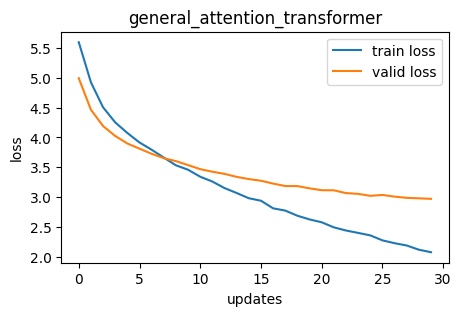

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(5, 3))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_losses, label = 'train loss')
ax.plot(valid_losses, label = 'valid loss')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('loss')
ax.set_title('general_attention_transformer')

In [ ]:
model.load_state_dict(torch.load(save_path))
test_loss = evaluate(model, test_loader, criterion_gen, test_loader_length)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 2.920 | Test PPL:  18.541 |


#### - multiplicative attention

In [ ]:
model = initialize_model("multiplicative_attention")

#training hyperparameters
lr = 0.0001
optimizer_multi = optim.Adam(model.parameters(), lr=lr)
criterion_multi = nn.CrossEntropyLoss(ignore_index = PAD_IDX) #combine softmax with cross entropy

print(count_parameters(model))

196096
256000
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
  1024
    32
 65536
   256
131072
   512
131072
   256
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
  1024
    32
 65536
   256
131072
   512
131072
   256
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
  1024
    32
 65536
   256
131072
   512
131072
   256
158464
256000
   256
   256
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
  1024
    32
 65536
   256
 65536
   256
 65536
   256
 65536
   256
  1024
    32
 65536
   256
131072
   512
131072
   256
   256
   256
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
  1024
    32
 65536
   256
 65536
   256
 65536
   256
 65536
   256
  1024
    32
 65536
   256
131072
   512
131072
   256
   256
   256
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
  1024
    32
 65536
   256
 65536
   256
 65536
   256
 65536
   256
  1024
    32
 65536

In [ ]:
best_valid_loss = float('inf')
best_train_loss = float('inf')
best_train_ppl  = float('inf')
best_valid_ppl  = float('inf')

num_epochs = 30
clip = 1
save_path = 'models/multiplicative_attention.pt'

train_losses = []
valid_losses = []


for epoch in range(num_epochs):
    
    start_time = time.time()

    train_loss = train(model, train_loader, optimizer_multi, criterion_multi, clip, train_loader_length)
    valid_loss = evaluate(model, valid_loader, criterion_multi, val_loader_length)
    
    # For plotting
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    train_ppl = math.exp(train_loss)
    valid_ppl = math.exp(valid_loss)
    
    if train_loss < best_train_loss:
        best_train_loss = train_loss
        best_train_ppl = train_ppl
        
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        best_valid_ppl = valid_ppl
        torch.save(model.state_dict(), save_path)
    
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {train_ppl:7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {valid_ppl:7.3f}')

print(f'Best Train Loss: {best_train_loss:.3f} | Best Train PPL: {best_train_ppl:7.3f}')
print(f'Best Val. Loss: {best_valid_loss:.3f} | Best Val. PPL: {best_valid_ppl:7.3f}')

Epoch: 01 | Time: 0m 11s
	Train Loss: 5.603 | Train PPL: 271.288
	 Val. Loss: 4.995 |  Val. PPL: 147.611
Epoch: 02 | Time: 0m 11s
	Train Loss: 4.909 | Train PPL: 135.554
	 Val. Loss: 4.428 |  Val. PPL:  83.794
Epoch: 03 | Time: 0m 11s
	Train Loss: 4.504 | Train PPL:  90.352
	 Val. Loss: 4.163 |  Val. PPL:  64.253
Epoch: 04 | Time: 0m 11s
	Train Loss: 4.237 | Train PPL:  69.209
	 Val. Loss: 3.989 |  Val. PPL:  54.022
Epoch: 05 | Time: 0m 11s
	Train Loss: 4.058 | Train PPL:  57.864
	 Val. Loss: 3.885 |  Val. PPL:  48.686
Epoch: 06 | Time: 0m 11s
	Train Loss: 3.911 | Train PPL:  49.967
	 Val. Loss: 3.792 |  Val. PPL:  44.351
Epoch: 07 | Time: 0m 11s
	Train Loss: 3.768 | Train PPL:  43.277
	 Val. Loss: 3.720 |  Val. PPL:  41.275
Epoch: 08 | Time: 0m 11s
	Train Loss: 3.640 | Train PPL:  38.087
	 Val. Loss: 3.646 |  Val. PPL:  38.333
Epoch: 09 | Time: 0m 11s
	Train Loss: 3.543 | Train PPL:  34.569
	 Val. Loss: 3.609 |  Val. PPL:  36.915
Epoch: 10 | Time: 0m 11s
	Train Loss: 3.449 | Train PPL

Text(0.5, 1.0, 'multiplicative_attention_transformer')

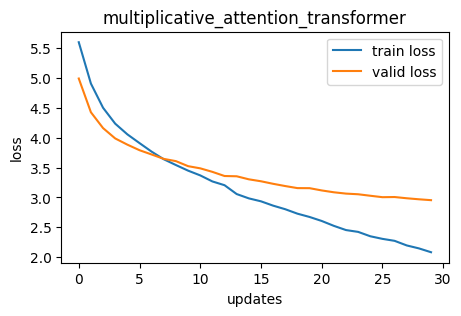

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(5, 3))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_losses, label = 'train loss')
ax.plot(valid_losses, label = 'valid loss')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('loss')
ax.set_title('multiplicative_attention_transformer')

In [ ]:
model.load_state_dict(torch.load(save_path))
test_loss = evaluate(model, test_loader, criterion_multi, test_loader_length)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 2.971 | Test PPL:  19.520 |


#### - additive attention

In [ ]:
model = initialize_model("additive_attention")

import torch.optim as optim

#training hyperparameters
lr = 0.0001
optimizer_add = optim.Adam(model.parameters(), lr=lr)
criterion_add = nn.CrossEntropyLoss(ignore_index = PAD_IDX) #combine softmax with cross entropy

print(count_parameters(model))

196096
256000
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
  1024
    32
  1024
    32
    32
     1
 65536
   256
131072
   512
131072
   256
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
  1024
    32
  1024
    32
    32
     1
 65536
   256
131072
   512
131072
   256
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
  1024
    32
  1024
    32
    32
     1
 65536
   256
131072
   512
131072
   256
158464
256000
   256
   256
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
  1024
    32
  1024
    32
    32
     1
 65536
   256
 65536
   256
 65536
   256
 65536
   256
  1024
    32
  1024
    32
    32
     1
 65536
   256
131072
   512
131072
   256
   256
   256
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
  1024
    32
  1024
    32
    32
     1
 65536
   256
 65536
   256
 65536
   256
 65536
   256
  1024
    32
  1024
    32
    32
     1
 65536
   256
131072

In [ ]:
best_valid_loss = float('inf')
best_train_loss = float('inf')
best_train_ppl  = float('inf')
best_valid_ppl  = float('inf')

num_epochs = 30
clip = 1
save_path = 'models/additive_attention.pt'

train_losses = []
valid_losses = []

for epoch in range(num_epochs):
    
    start_time = time.time()

    train_loss = train(model, train_loader, optimizer_add, criterion_add, clip, train_loader_length)
    valid_loss = evaluate(model, valid_loader, criterion_add, val_loader_length)
    
    # For plotting
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    train_ppl = math.exp(train_loss)
    valid_ppl = math.exp(valid_loss)
    
    if train_loss < best_train_loss:
        best_train_loss = train_loss
        best_train_ppl = train_ppl
        
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        best_valid_ppl = valid_ppl
        torch.save(model.state_dict(), save_path)
    
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {train_ppl:7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {valid_ppl:7.3f}')

print(f'Best Train Loss: {best_train_loss:.3f} | Best Train PPL: {best_train_ppl:7.3f}')
print(f'Best Val. Loss: {best_valid_loss:.3f} | Best Val. PPL: {best_valid_ppl:7.3f}')

Epoch: 01 | Time: 0m 11s
	Train Loss: 5.796 | Train PPL: 329.132
	 Val. Loss: 5.183 |  Val. PPL: 178.154
Epoch: 02 | Time: 0m 11s
	Train Loss: 5.050 | Train PPL: 156.052
	 Val. Loss: 4.547 |  Val. PPL:  94.386
Epoch: 03 | Time: 0m 11s
	Train Loss: 4.560 | Train PPL:  95.620
	 Val. Loss: 4.205 |  Val. PPL:  67.022
Epoch: 04 | Time: 0m 11s
	Train Loss: 4.258 | Train PPL:  70.681
	 Val. Loss: 4.031 |  Val. PPL:  56.304
Epoch: 05 | Time: 0m 11s
	Train Loss: 4.067 | Train PPL:  58.390
	 Val. Loss: 3.902 |  Val. PPL:  49.498
Epoch: 06 | Time: 0m 11s
	Train Loss: 3.926 | Train PPL:  50.726
	 Val. Loss: 3.801 |  Val. PPL:  44.751
Epoch: 07 | Time: 0m 12s
	Train Loss: 3.772 | Train PPL:  43.446
	 Val. Loss: 3.723 |  Val. PPL:  41.396
Epoch: 08 | Time: 0m 11s
	Train Loss: 3.647 | Train PPL:  38.361
	 Val. Loss: 3.637 |  Val. PPL:  37.965
Epoch: 09 | Time: 0m 11s
	Train Loss: 3.518 | Train PPL:  33.716
	 Val. Loss: 3.583 |  Val. PPL:  35.985
Epoch: 10 | Time: 0m 11s
	Train Loss: 3.447 | Train PPL

Text(0.5, 1.0, 'additive_attention_transformer')

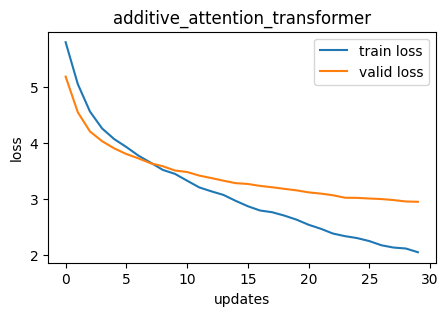

In [ ]:

import matplotlib.pyplot as plt
fig = plt.figure(figsize=(5, 3))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_losses, label = 'train loss')
ax.plot(valid_losses, label = 'valid loss')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('loss')
ax.set_title('additive_attention_transformer')

In [ ]:
model.load_state_dict(torch.load(save_path))
test_loss = evaluate(model, test_loader, criterion_add, test_loader_length)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 2.874 | Test PPL:  17.700 |
